In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

# Fonctions essentiel

In [3]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

# Segmentation de noyau

Prise en main d'un code pour segmenter des images et comment mettre en place un pipeline de traitement d'images.

Lien : https://www.kaggle.com/code/balraj98/unet-for-building-segmentation-pytorch

- Comment mettre en place un pipeline de traitement d'images ?

Un pipeline est un algorithme structuré en trois parties. Il y a d'abord:

- Entrée : RGB

- Sortie : Masque binaire

Trois parties

- Pré-traitement : Resize pour économiser de la mémoire

- Traitement : Création d'une carte de probabilité avec UNet à partir d'images RGB

- Post-traitement : Seuillage

On a une base de données contenant des images RGB et des masques binaires.

- Comment lancer un projet d'entrainement d'un modèle ?

# Fonctions essentielles

In [4]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import matplotlib.patches as mpatches
import torch

def get_data(path, train=True):
    """
    Loads and preprocesses image data.

    Args:
        path (str): Path to the directory containing the image data.
        train (bool, optional): Flag indicating if the data is for training.
                                 Defaults to True.

    Returns:
        tuple or ndarray: If train is True, returns a tuple containing the
                          image data (X) and corresponding masks (Y).
                          If train is False, returns only the image data (X).
    """
    # Get the list of image IDs
    ids = next(os.walk(path))[1]

    # Initialize arrays to store image data and masks
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

    # Initialize masks array only if train is True
    if train:
        Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    print('Getting and resizing images ... ')
    sys.stdout.flush()

    # Iterate through each image ID
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        path_new = path + id_

        # Read and resize the image
        img = imread(path_new + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img

        # Read and process masks only if train is True
        if train:
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
            for mask_file in next(os.walk(path_new + '/masks/'))[2]:
                mask_ = imread(path_new + '/masks/' + mask_file)
                mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                              preserve_range=True), axis=-1)
                mask = np.maximum(mask, mask_)
            Y[n] = mask

    # Return image data and masks (if train is True) or only image data
    if train:
        return X, Y
    else:
        return X

def upload_data(x_data,y_data,main_path,dataset):
  from PIL import Image
  from tqdm import tqdm

  if not os.path.exists(os.path.join(main_path,dataset)):
    os.mkdir(os.path.join(main_path,dataset))

  if not os.path.exists(os.path.join(main_path,dataset,"images")):
    os.mkdir(os.path.join(main_path,dataset,"images"))

    # Images
    for ix in tqdm(range(x_data.shape[0]),desc='Images'):
      img = x_data[ix,...].astype('uint8')

      im = Image.fromarray(img)
      im.save(os.path.join(main_path,dataset,"images","img_"+str(ix)+".png"))

  if not os.path.exists(os.path.join(main_path,dataset,"mask")):
    os.mkdir(os.path.join(main_path,dataset,"mask"))

    # Msk
    for ix in tqdm(range(y_data.shape[0]),desc='Mask'):
      msk = y_data[ix,...]
      msk_ = np.where(msk[:,:,0]!=0,255,0)
      msk_ = msk_.astype('uint8')

      im = Image.fromarray(msk_)
      im.save(os.path.join(main_path,dataset,"mask","img_"+str(ix)+".png"))

  A = os.listdir(os.path.join(main_path,dataset,"images"))
  B = os.listdir(os.path.join(main_path,dataset,"mask"))
  print(dataset)
  print('Images:',len(A))
  print('Mask:',len(B))

In [238]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    y_true = torch.from_numpy(y_true)
    y_pred = torch.from_numpy(y_pred)
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true*y_true) + torch.sum(y_pred*y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def image_confusion(GT,predict):
  # Conversion en booléen directement
  GT_new = GT.astype('uint8')


  GT_new = (GT_new!=0).astype('uint8')
  predict = (predict!=0).astype('uint8')

  GT_new = GT_new[:,:,0]
  predict = predict[:,:,0]
  # Création de l'image de sortie avec NumPy
  IMAGE_OUTPUT = np.zeros((GT.shape[0],GT.shape[1], 3), dtype="uint8")

  # Conditions pour chaque cas
  TP = (predict == 1) & (GT_new == 1)  # True Positive (Blanc)
  FP = (predict == 1) & (GT_new == 0)  # False Positive (Rouge)
  FN = (predict == 0) & (GT_new == 1)  # False Negative (Vert)
  TN = (predict == 0) & (GT_new == 0)  # True Negative (Noir)

  # Assignation des couleurs selon les masques
  IMAGE_OUTPUT[TP] = [255, 255, 255]  # Blanc
  IMAGE_OUTPUT[FP] = [255, 0, 0]      # Rouge
  IMAGE_OUTPUT[FN] = [0, 255, 0]      # Vert
  IMAGE_OUTPUT[TN] = [0, 0, 0]        # Noir
  IMAGE_OUTPUT = np.array(IMAGE_OUTPUT)

  return IMAGE_OUTPUT

def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    dico = {}
    for idx, (name, image) in enumerate(images.items()):
      if name=='ground_truth_mask':
        dico[name]=image
      if name=='predicted_mask':
        dico[name]=image
      plt.subplot(1, n_images, idx + 1)
      plt.xticks([]);
      plt.yticks([])
      # get title from the parameter names
      plt.title(name.replace('_',' ').title(), fontsize=20)
      plt.imshow(image)

    if 'ground_truth_mask' in dico and 'predicted_mask' in dico:
      gt = dico['ground_truth_mask']
      pred = dico['predicted_mask']
      IMAGE_OUTPUT = image_confusion(gt,pred)
      dice = dice_coefficient(gt, pred)
      plt.imshow(IMAGE_OUTPUT)
      legend_patches = [
            mpatches.Patch(color='white', label='True Positive (Blanc)'),
            mpatches.Patch(color='red', label='False Positive (Rouge)'),
            mpatches.Patch(color='green', label='False Negative (Vert)'),
            mpatches.Patch(color='black', label='True Negative (Noir)'),
        ]
      plt.legend(handles=legend_patches, loc='upper left',bbox_to_anchor=(1.1,.9), fontsize=10, frameon=True)
      plt.title(f"Image de confusion\n Dice {np.round(dice.item(),3)}")
      plt.axis('off')
      plt.show()

def vis_pred(random_idx,valid_dataset,DEVICE):
    # random_idx = random.randint(0, len(valid_dataset)-1)
    image, gt_mask = valid_dataset[random_idx]
    image_vis = crop_image(valid_dataset[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('cell')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    # cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    image_vis_tr = np.transpose(image_vis, (1, 2, 0))

    visualize(
        original_image = image_vis_tr,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

def vis_prob_maps(random_idx,valid_dataset,DEVICE):
    # random_idx = random.randint(0, len(valid_dataset)-1)
    image, gt_mask = valid_dataset[random_idx]
    image_vis = crop_image(valid_dataset[random_idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('cell')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    # cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    image_vis_tr = np.transpose(image_vis, (1, 2, 0))

    visualize(
        original_image = image_vis_tr,
        ground_truth_mask = gt_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

class BCEWithLogitsLossExample(nn.Module):
    def __init__(self, pos_weight=1.0, device='cuda'):
        super(BCEWithLogitsLossExample, self).__init__()
        self.pos_weight = pos_weight
        self.device = device
        self.__name__ = "BCELoss"

    def forward(self, inputs, targets):
        # Assurez-vous que les tenseurs sont sur le même appareil (device)
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        # Calcul de la Binary Cross Entropy avec poids pour la classe positive
        pos_weight_tensor = torch.tensor([self.pos_weight], device=self.device, dtype=torch.float32)

        # Création de la fonction de perte BCE avec logits
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

        # Calcul de la perte
        loss = loss_fn(inputs, targets)

        return loss

class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0, device='cuda'):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        self.device = device
        self.__name__ = "WeightedBCELoss"

    def forward(self, inputs, targets):
        # Assurez-vous que les tenseurs sont sur le même appareil (device)
        inputs = inputs.to(self.device)
        targets = targets.to(self.device)

        # Calcul du Binary Cross Entropy avec poids pour la classe positive
        pos_weight_tensor = torch.tensor([self.pos_weight], device=self.device, dtype=torch.float32)

        # Calcul de la perte avec BCEWithLogitsLoss
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
        loss = loss_fn(inputs, targets)

        return loss

def format_dataset(test_dataset):
  pred_test_t = []
  for idx in range(len(test_dataset)):
      image, gt_mask = test_dataset[idx]
      x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
      pred_mask = best_model(x_tensor) # Predict test image
      pred_mask = pred_mask.detach().squeeze().cpu().numpy()
      pred_mask = np.transpose(pred_mask,(1,2,0)) # Convert pred_mask from `CHW` format to `HWC` format
      x = np.argmax(pred_mask, axis = -1)
      pred_mask = np.where(x==0,255,0)
      pred_test_t.append(pred_mask)
  pred_test_t = np.array(pred_test_t)
  gt_mask_t = []
  for idx in range(len(test_dataset)):
      _, gt_mask = test_dataset[idx]
      gt_mask = np.transpose(gt_mask,(1,2,0))
      x = np.argmax(gt_mask, axis = -1)
      gt_mask = np.where(x==0,255,0)
      gt_mask_t.append(gt_mask)
  gt_mask_t = np.array(gt_mask_t)
  return pred_test_t,gt_mask_t

class DiceCoefficient(torch.nn.Module):
    def __init__(self):
        super(DiceCoefficient, self).__init__()
        self.__name__ = "Dice_score"

    def forward(self, inputs, targets):
        # Calcul de l'intersection et de l'union
        intersection = (inputs * targets).sum(dim=(1, 2, 3))
        union = (inputs*inputs).sum(dim=(1, 2, 3)) + (targets*targets).sum(dim=(1, 2, 3))

        # Calcul du coefficient de Dice
        dice = (2.0 * intersection) / (union + 1e-6)  # Éviter la division par zéro

        return dice.mean()  # Retourner la moyenne sur le lot

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    y_true = torch.from_numpy(y_true)
    y_pred = torch.from_numpy(y_pred)
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true*y_true) + torch.sum(y_pred*y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


class UNet(nn.Module):
    """
    UNet pour une segmentation binaire : classe 0 fond / classe 1 objet
    Hyperparamètres :
    - Nombre de filtre
    """
    def __init__(self, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Encoder : Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Decoder : Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

# Préparation de la base de données

In [6]:
from google.colab import drive
root = '/content/gdrive/'
drive.mount(root)

# create permanent directory in gdrive
data_dir_path = '/MyDrive/Segmentation/'
os.makedirs(os.path.join(root,data_dir_path), exist_ok=True)
os.listdir(os.path.join(root,data_dir_path))

Mounted at /content/gdrive/


[]

In [5]:
!unzip -q "/content/gdrive/MyDrive/Segmentation/data.zip"

In [8]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'data/nuclei_train_data/'
TEST_PATH = 'data/nuclei_val_data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

X, Y = get_data(TRAIN_PATH, train=True)
X_test,Y_test = get_data(TEST_PATH, train=True)

Getting and resizing images ... 


100%|██████████| 536/536 [03:38<00:00,  2.46it/s]

Getting and resizing images ... 



100%|██████████| 134/134 [01:05<00:00,  2.06it/s]


In [9]:
print('Train data shape:', X.shape)
print('Train label shape:', Y.shape)
print('Test data shape:', X_test.shape)
print('Test label shape:', Y_test.shape)

Train data shape: (536, 256, 256, 3)
Train label shape: (536, 256, 256, 1)
Test data shape: (134, 256, 256, 3)
Test label shape: (134, 256, 256, 1)


## Importer les data dans notre repertoire

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42) #text_size=0.3 (à moi, 0.2)

In [14]:
DATA_DIR = '/content/gdrive/MyDrive/Segmentation'
upload_data(x_train,y_train,DATA_DIR,"Train")
upload_data(x_val,y_val,DATA_DIR,"Val")
upload_data(X_test,Y_test,DATA_DIR,"Test")

NameError: name 'x_train' is not defined

In [8]:
DATA_DIR = '/content/gdrive/MyDrive/Segmentation'
x_train_dir = os.path.join(DATA_DIR, 'Train','images')
y_train_dir = os.path.join(DATA_DIR, 'Train','mask')

x_valid_dir = os.path.join(DATA_DIR, 'Val','images')
y_valid_dir = os.path.join(DATA_DIR, 'Val','mask')

x_test_dir = os.path.join(DATA_DIR, 'Test','images')
y_test_dir = os.path.join(DATA_DIR, 'Test','mask')

In [9]:
class_names = ['cell','background']
class_rgb_values = [[255,255,255],[0,0,0]]

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['cell','background']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [10]:
# dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
# random_idx = random.randint(0, len(dataset)-1)
# image, mask = dataset[2]

In [214]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

test_dataset = BuildingsDataset(
    x_test_dir, y_test_dir,
    preprocessing=get_preprocessing(preprocessing_fn=None),
    class_rgb_values=select_class_rgb_values,
)

# Modèle UNet

In [218]:
class DoubleConv(nn.Module):
    """
    Deux blocks de convolutions successifs :
    Conv2d : Convolution entre une matrice et un noyau
    BatchNorm2d : Normalisation par lots
    ReLU : Fonction d'activation
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    """
    Encoder : sous-échantillonnage de l'image
    Résultat de la double convolution puis application d'un max-pooling sur une matrice pour réduire les dimensions de cette matrice
    """
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)


class UpBlock(nn.Module):
    """
    Decoder : sur-échantillonnage de l'image
    nn.ConvTranspose2d : Concatenation de la couche précédente avec la sortie du max-pooling du même niveau
    DoubleConv : Application de deux blocks de convolutions
    """
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    """
    UNet pour une segmentation binaire : classe 0 fond / classe 1 objet
    Hyperparamètres :
    - Nombre de filtre
    """
    def __init__(self, n_filters, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Encoder : Downsampling Path
        self.down_conv1 = DownBlock(3, n_filters*4)
        self.down_conv2 = DownBlock(n_filters*4, n_filters*8)
        self.down_conv3 = DownBlock(n_filters*8, n_filters*16)
        self.down_conv4 = DownBlock(n_filters*16, n_filters*32)
        # Bottleneck
        self.double_conv = DoubleConv(n_filters*32, n_filters*64)
        # Decoder : Upsampling Path
        self.up_conv4 = UpBlock(n_filters*32 + n_filters*64, n_filters*32, self.up_sample_mode)
        self.up_conv3 = UpBlock(n_filters*16 + n_filters*32, n_filters*16, self.up_sample_mode)
        self.up_conv2 = UpBlock(n_filters*8 + n_filters*16, n_filters*8, self.up_sample_mode)
        self.up_conv1 = UpBlock(n_filters*8 + n_filters*4, n_filters*4, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(n_filters*4, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

# Get UNet model
model = UNet(n_filters=5)

Hyperparamètre de l'architecture :

- Nombre de filtre

# Entrainement

Définition des hyperparamètres d'entrainements:

- Nombre epoch
- Batch size
- Fonction de perte : WeightedBCELoss, BCEWithLogitsLossExample
- Métrique
- Algorithme d'optimisation


In [180]:
from collections import Counter
neg,pos = [],[]
for ix in range(len(train_dataset)):
  _, mask = train_dataset[ix]
  dico = dict(Counter(mask.flatten()))
  neg.append(dico[0])
  pos.append(dico[1])

pos_weight = np.sum(pos)/(np.sum([neg,pos]))

In [219]:
import segmentation_models_pytorch.utils

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 12

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
# loss = WeightedBCELoss(pos_weight=pos_weight, device=DEVICE)
loss = BCEWithLogitsLossExample(device=DEVICE)
# define metrics
metrics = [
    DiceCoefficient(),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0007),
])

checkpoint_filepath = os.path.join(DATA_DIR,'best_UNet.pth')

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

Entrainement du modèle

In [220]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [221]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['Dice_score']:
          best_iou_score = valid_logs['Dice_score']
          torch.save(model, checkpoint_filepath)
          print('Model saved!')


Epoch: 0
valid: 100%|██████████| 7/7 [00:02<00:00,  3.37it/s, BCELoss - 0.4437, Dice_score - 0.4661]
Model saved!

Epoch: 1
valid: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s, BCELoss - 0.3843, Dice_score - 0.4593]

Epoch: 2
valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, BCELoss - 0.4939, Dice_score - 0.2412]

Epoch: 3
valid: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s, BCELoss - 0.3058, Dice_score - 0.4257]

Epoch: 4
valid: 100%|██████████| 7/7 [00:02<00:00,  2.64it/s, BCELoss - 0.2552, Dice_score - 0.4119]

Epoch: 5
valid: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s, BCELoss - 0.7825, Dice_score - 0.00532]

Epoch: 6
valid: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s, BCELoss - 0.1994, Dice_score - 0.3389]

Epoch: 7
valid: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s, BCELoss - 0.2246, Dice_score - 0.3763]

Epoch: 8
valid: 100%|██████████| 7/7 [00:03<00:00,  2.25it/s, BCELoss - 0.1891, Dice_score - 0.3424]

Epoch: 9
valid: 100%|██████████| 7/7 [00:03<00:00,  2.32it/s, BCELo

In [222]:
# load best saved model checkpoint from the current run
if os.path.exists(checkpoint_filepath):
    best_model = torch.load(checkpoint_filepath, map_location=DEVICE)
    print('Loaded UNet model from this run.')

Loaded UNet model from this run.


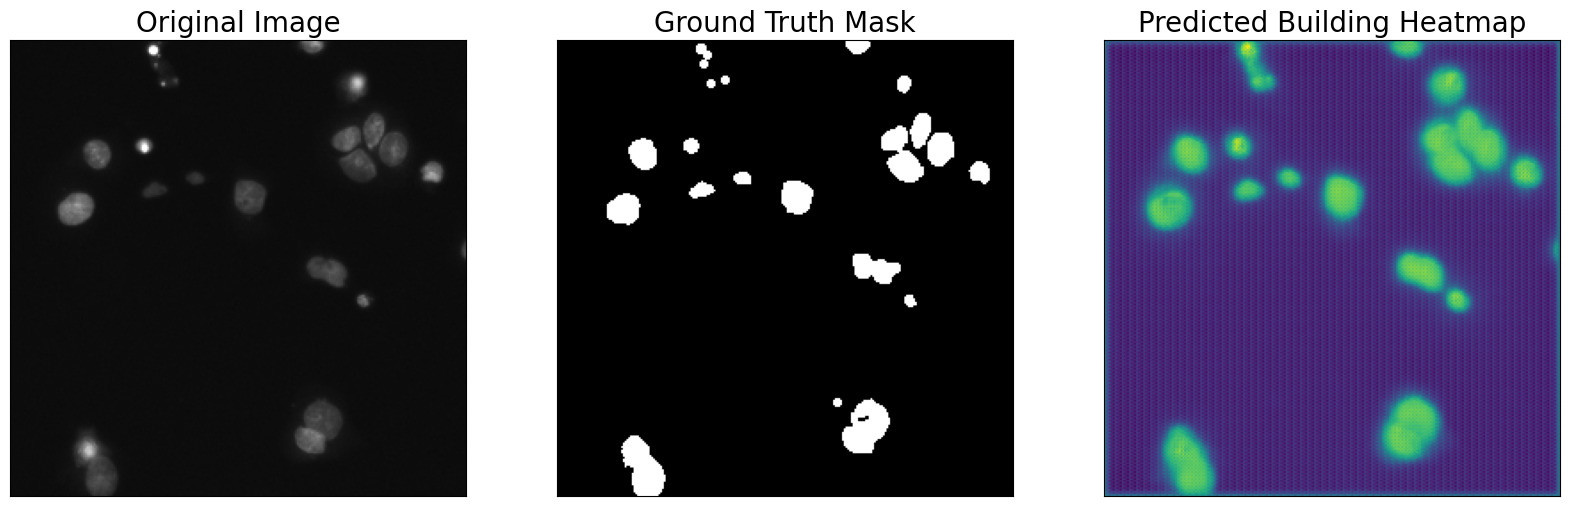

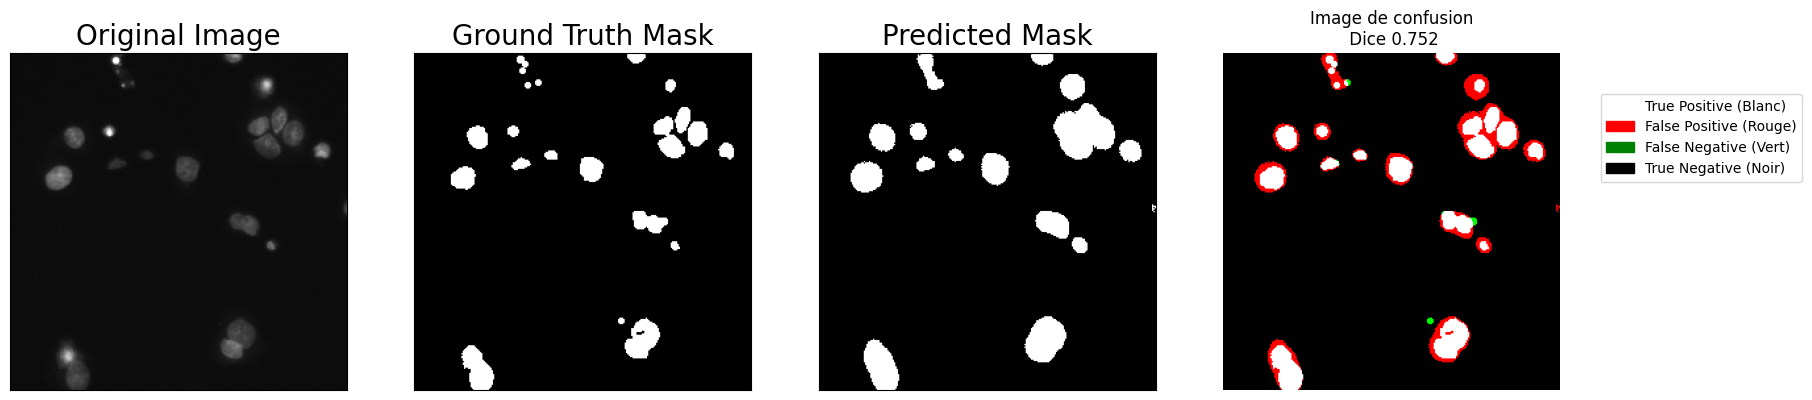

In [240]:
idx = np.random.randint(0, len(valid_dataset)-1)
vis_prob_maps(idx,valid_dataset,DEVICE)
vis_pred(idx,valid_dataset,DEVICE)

## Evaluation sur le val

In [225]:
val_epoch = smp.utils.train.ValidEpoch(
    best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = val_epoch.run(valid_loader)
print("Evaluation on validation Data: ")
print(f"Mean Dice: {valid_logs['Dice_score']:.4f}")
print(f"Mean Loss: {valid_logs['BCELoss']:.4f}")

valid: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s, BCELoss - 0.4437, Dice_score - 0.4661]
Evaluation on validation Data: 
Mean Dice: 0.4661
Mean Loss: 0.4437


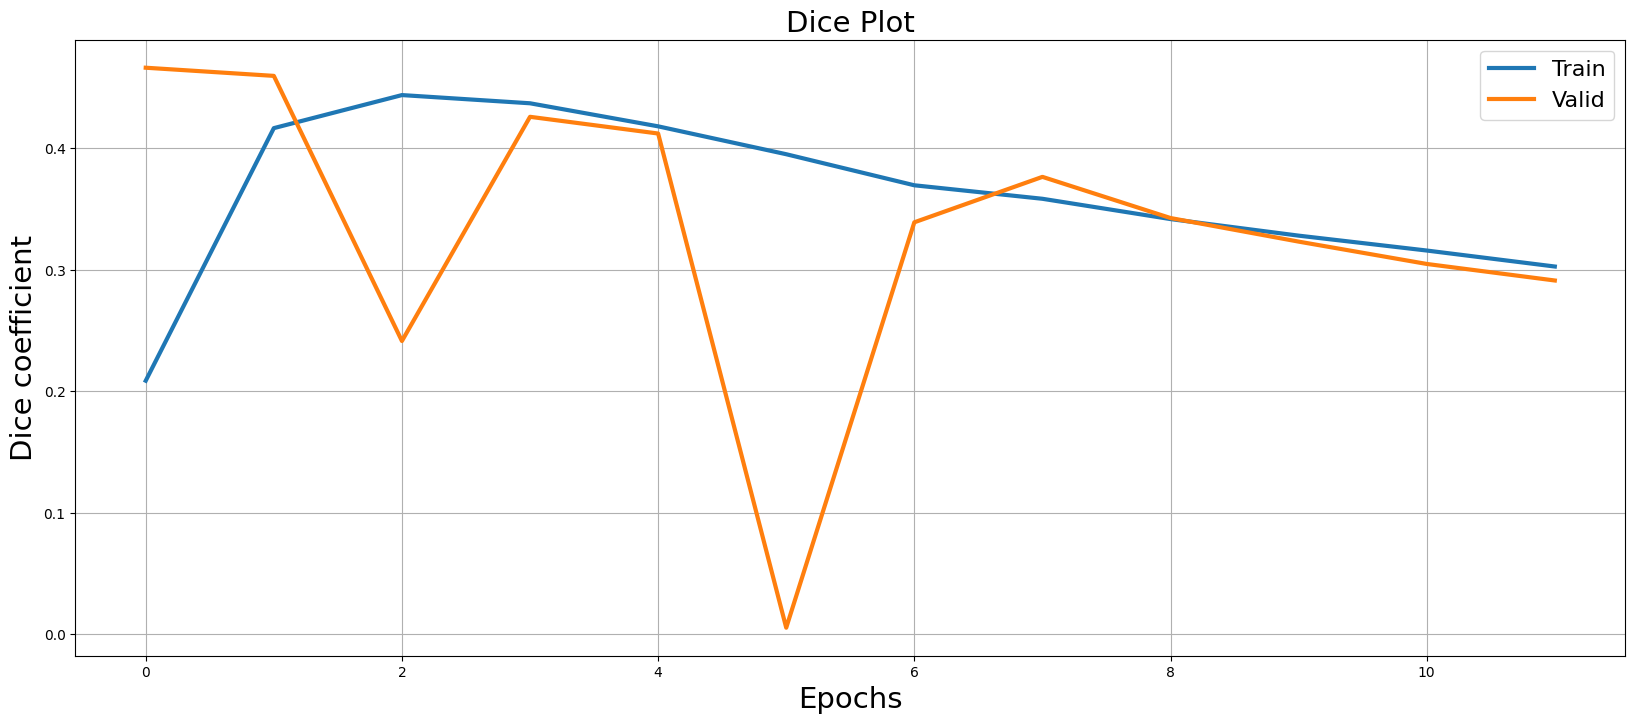

In [226]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.Dice_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.Dice_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice coefficient', fontsize=21)
plt.title('Dice Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_plot.png')
plt.show()

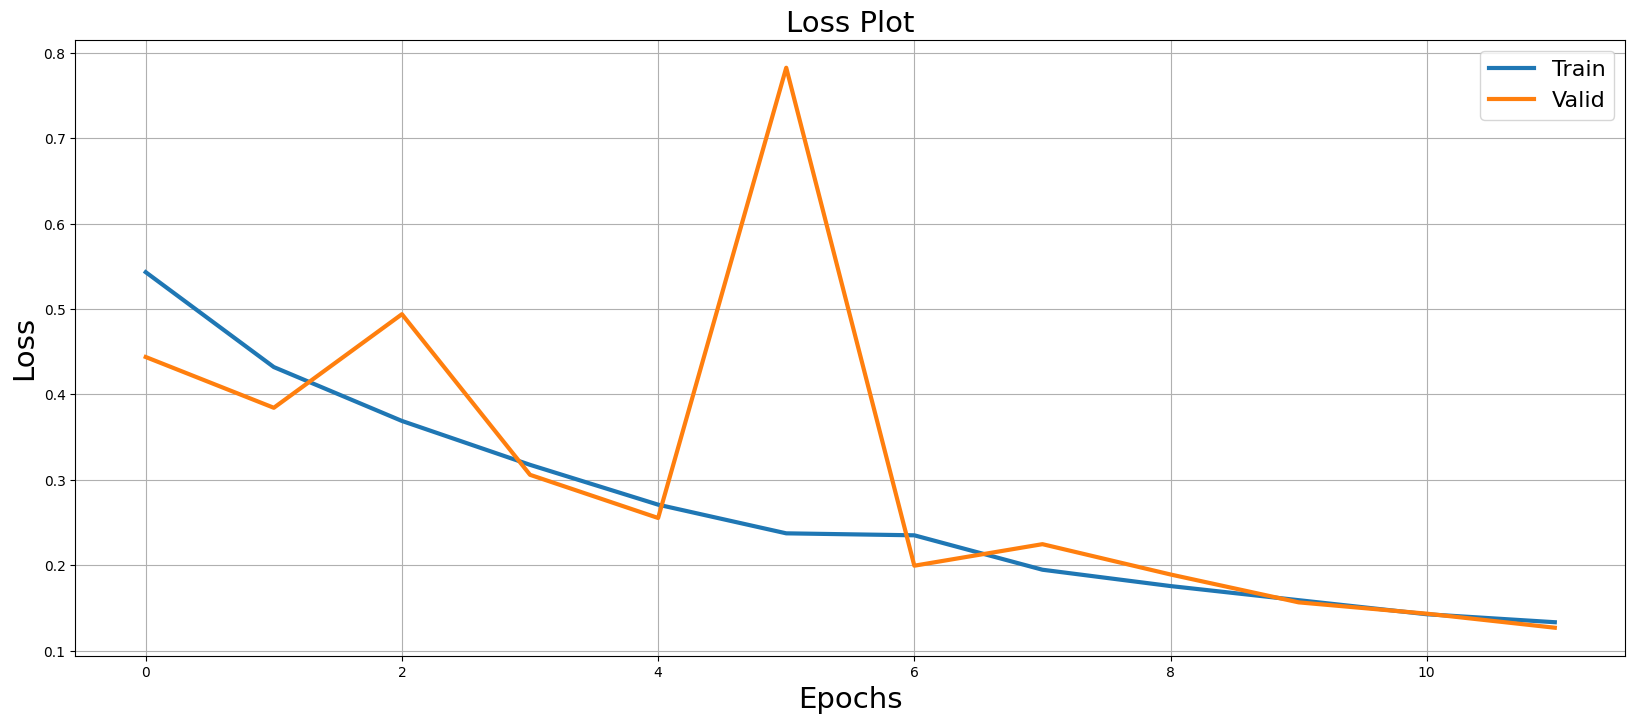

In [228]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.BCELoss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.BCELoss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Loss', fontsize=21)
plt.title('Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('loss_plot.png')
plt.show()

# Evaluation du meilleur modèle sur le test

In [229]:
# load best saved model checkpoint from the current run
if os.path.exists(checkpoint_filepath):
    best_model = torch.load(checkpoint_filepath, map_location=DEVICE)
    print('Loaded UNet model from this run.')

Loaded UNet model from this run.


In [231]:
test_epoch = smp.utils.train.ValidEpoch(
    best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_loader)
print("Evaluation on test Data: ")
print(f"Mean Dice: {valid_logs['Dice_score']:.4f}")
print(f"Mean Loss: {valid_logs['BCELoss']:.4f}")

valid: 100%|██████████| 134/134 [00:03<00:00, 36.37it/s, BCELoss - 0.4435, Dice_score - 0.4712]
Evaluation on test Data: 
Mean Dice: 0.4712
Mean Loss: 0.4435


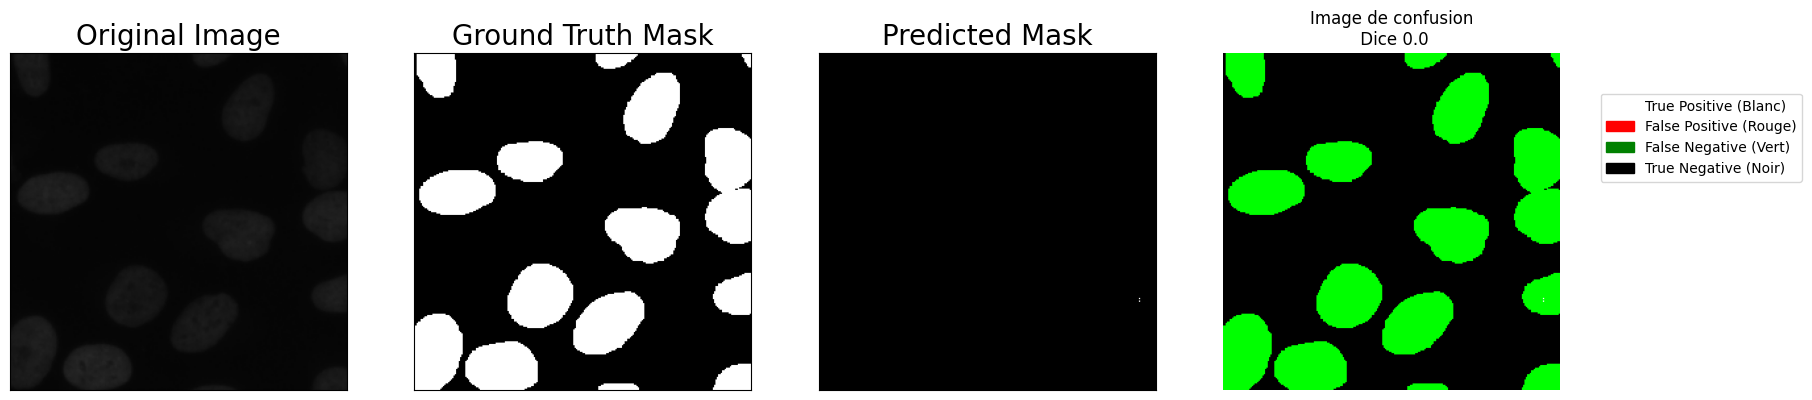

In [241]:
for idx in range(1):
  vis_pred(idx,test_dataset,DEVICE)

In [242]:
pred_test_t,gt_mask_t =  format_dataset(test_dataset)
dice = dice_coefficient(gt_mask_t, pred_test_t).item()
print("Dice coefficient:", np.around(dice,3))

Dice coefficient: 0.635


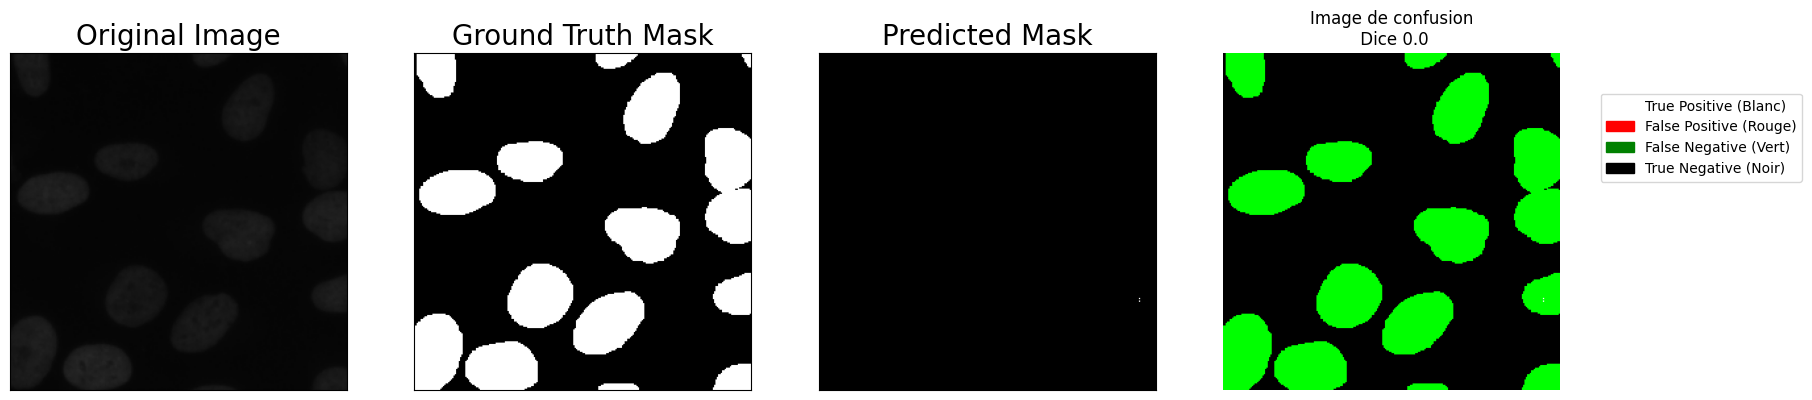

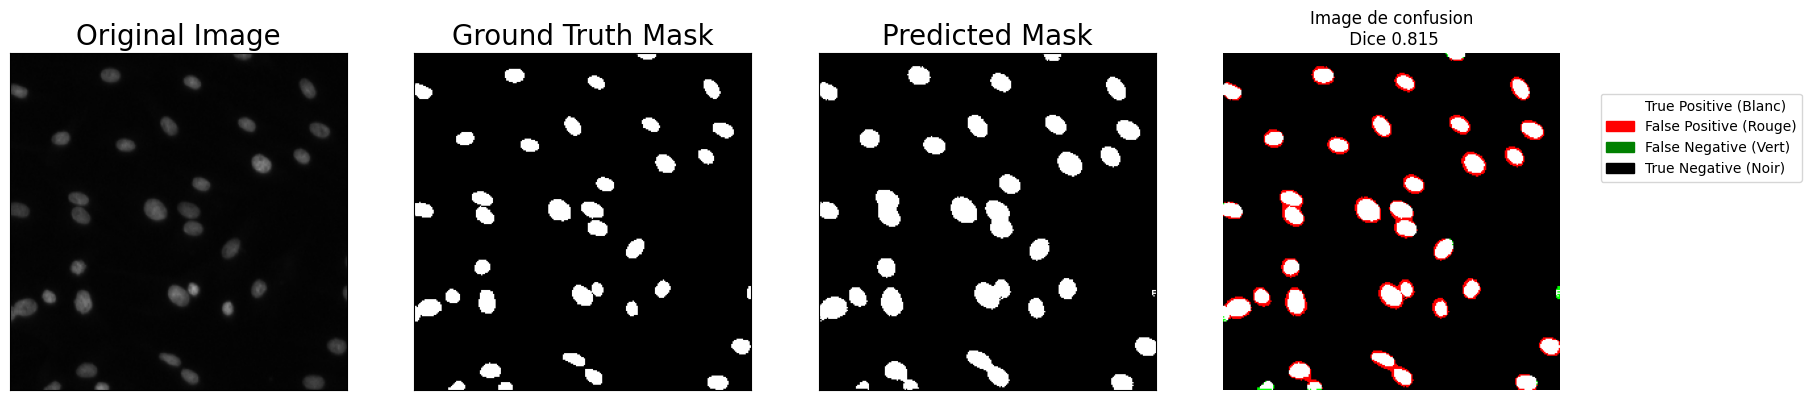

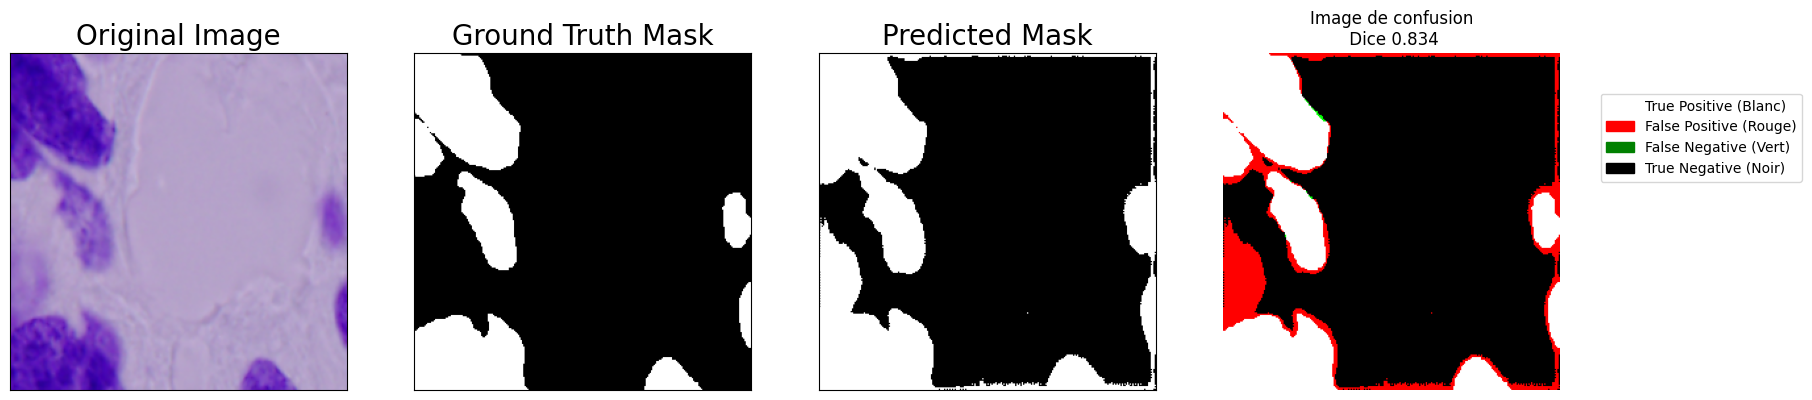

In [243]:
for idx in range(3):
  vis_pred(idx,test_dataset,DEVICE)

# Extra : comment améliorer mes résultats ?

La performance d'un pipepline repose sur la qualité des images. Pour une qualité d'images, le qualité de la segmentation est influencé par :
- Choix des valeurs des hyperparamètres sur l'architecture
- Structure du pipeline